In [94]:
from collections import Counter
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.stats import lognorm
from typing import Dict, List, Tuple

In [2]:
# NOTE: The report is found towards the end of this notebook, under the section titled "Report"

### Helper Code

In [3]:
# Class that holds the various parameters used in the simulations
class Parameters:
    def __init__(self, masks: bool = False, e_mu: float = 1.0, e_sigma: float = 1.0, 
                 i_mu: float = 2.25, i_sigma: float = 0.105, p_1c: float = 0.12, 
                 beta: float = -0.00504) -> None:
        self.masks = masks
        self.e_mu = e_mu
        self.e_sigma = e_sigma
        self.i_mu = i_mu
        self.i_sigma = i_sigma
        self.p_1c = p_1c
        self.beta = beta

In [4]:
# Generic state class
class State:
    def __init__(self, parameters: Parameters, color: str) -> None:
        self.parameters = parameters
        self.color = color

    def transition(self):
        pass


# Recovered state class
class Recovered(State):
    def __init__(self, parameters: Parameters, color: str = 'green') -> None:
        super().__init__(parameters, color)

    def transition(self) -> State:
        return self
    

# Recovered state class
class Infectious(State):
    def __init__(self, parameters: Parameters, color: str = 'red') -> None:
        super().__init__(parameters, color)
        mu, sigma = self.parameters.i_mu, self.parameters.i_sigma
        self.n_days_to_recovered = int(np.ceil(np.random.lognormal(mu, sigma, 1)[0]))
        self.n_days_infectious = 0

    def prob_infection(self) -> float:
        p_1c = self.parameters.p_1c * 0.35 if self.parameters.masks else self.parameters.p_1c
        beta = self.parameters.beta
        numerator = (p_1c / (1 - p_1c)) * np.exp(beta * (self.n_days_infectious ** 3 - 1))
        denominator = 1 + numerator
        prob_infection = numerator / denominator

        return prob_infection

    def transition(self) -> State:
        if self.n_days_infectious >= self.n_days_to_recovered:
            return Recovered(self.parameters)
        
        self.n_days_infectious += 1

        return self
    

# Exposed state class
class Exposed(State):
    def __init__(self, parameters: Parameters, color: str = 'yellow') -> None:
        super().__init__(parameters, color)
        mu, sigma = self.parameters.e_mu, self.parameters.e_sigma
        self.n_days_to_infectious = int(np.ceil(np.random.lognormal(mu, sigma, 1)[0]))
        self.n_days_exposed = 0

    def transition(self) -> State:
        if self.n_days_exposed >= self.n_days_to_infectious:
            return Infectious(self.parameters)

        self.n_days_exposed += 1
        
        return self


# Susceptible state class
class Susceptible(State):
    def __init__(self, parameters: Parameters, neighbors: List, color: str = 'blue') -> None:
        super().__init__(parameters, color)
        self.neighbors = neighbors

    def transition(self) -> State:
        for neighbor in self.neighbors:
            if isinstance(neighbor.curr_state, Infectious):
                prob_infected = neighbor.curr_state.prob_infection()
                random_sample = np.random.uniform()
                
                if random_sample < prob_infected:
                    return Exposed(self.parameters)
                
        return self

In [5]:
# Agent class (used to represent each node in a graph)
class Agent:
    def __init__(self, initial_state_type: type, parameters: Parameters) -> None:
        assert issubclass(initial_state_type, State)
        self.initial_state_type = initial_state_type
        self.parameters = parameters
        self.neighbors = []
        self.curr_state = None

    def transition(self) -> None:
        assert self.curr_state is not None
        self.curr_state = self.curr_state.transition()

    def add_neighbor(self, neighbor) -> None:
        self.neighbors.append(neighbor)

    def set_initial_state(self) -> None:
        self.curr_state = self._initialize_state()

    def _initialize_state(self) -> State:
        if self.initial_state_type == Susceptible:
            return Susceptible(self.parameters, neighbors=self.neighbors)
        
        else:
            return self.initial_state_type(self.parameters)

In [6]:
# Population class (used to create and handle agents for a graph)
class Population:
    def __init__(self, graph: nx.Graph, percent_susceptible: float = 0.9, percent_exposed: float = 0.05, 
                 percent_infectious: float = 0.05, parameters: Parameters = Parameters()) -> None:
        assert percent_susceptible + percent_exposed + percent_infectious == 1.0
        self.graph = graph
        self.percent_susceptible = percent_susceptible
        self.percent_exposed = percent_exposed
        self.percent_infectious = percent_infectious
        self.parameters = parameters
        self.agents = self._initialize_agents()

    def _initialize_agents(self) -> Dict:
        agents = {}
        n_nodes = self.graph.number_of_nodes()
        node_numbers = list(range(n_nodes))
        np.random.shuffle(node_numbers)
        n_susceptible = int(n_nodes * self.percent_susceptible)
        n_exposed = int(n_nodes * self.percent_exposed)
        susceptible_indices = set(node_numbers[:n_susceptible])
        exposed_indices = set(node_numbers[n_susceptible:n_susceptible + n_exposed])
        infectious_indices = set(node_numbers[n_susceptible + n_exposed:])
        curr_index = 0

        assert len(susceptible_indices) == n_susceptible
        assert len(exposed_indices) == n_exposed
        assert len(infectious_indices) == n_nodes - (n_susceptible + n_exposed)

        for node in self.graph.nodes:
            if curr_index in susceptible_indices:
                initial_state_type = Susceptible

            elif curr_index in exposed_indices:
                initial_state_type = Exposed

            else:
                initial_state_type = Infectious

            agents[node] = Agent(initial_state_type, self.parameters)
            curr_index += 1

        for node in self.graph.nodes:
            neighbors = self.graph.neighbors(node)

            for neighbor in neighbors:
                neighbor_agent = agents[neighbor]
                agents[node].add_neighbor(neighbor_agent)

            agents[node].set_initial_state()

        return agents
    
    def transition(self) -> None:
        for agent in self.agents.values():
            agent.transition()
    
    def n_agents_with_type(self, state_type: type) -> int:
        assert issubclass(state_type, State)

        n_with_type = 0

        for agent in self.agents.values():
            n_with_type += 1 if isinstance(agent.curr_state, state_type) else 0

        return n_with_type
    
    def nodes_with_type(self, state_type: type) -> List[Tuple[object, str]]:
        nodes_with_type = [(node_label, agent.curr_state.color) for node_label, agent 
                           in self.agents.items() if isinstance(agent.curr_state, state_type)]
        
        return nodes_with_type
    
    def reset(self) -> None:
        self.agents = self._initialize_agents()

In [7]:
# Simulation class (used to run simulations on a population and track results)
class Simulation:
    def __init__(self, name: str, population: Population, n_iterations: int = 200, n_trials: int = 100) -> None:
        self.name = name
        self.population = population
        self.n_iterations = n_iterations
        self.n_trials = n_trials
        self.susceptible_counts, self.exposed_counts, self.infectious_counts, self.recovered_counts = [], [], [], []

    def run(self, animate: bool = False) -> None:
        node_colors = []

        for _ in range(self.n_trials):
            s_counts, e_counts, i_counts, r_counts = [], [], [], []

            for _ in range(self.n_iterations):
                for state_type, count_array in [(Susceptible, s_counts), 
                                                (Exposed, e_counts), 
                                                (Infectious, i_counts), 
                                                (Recovered, r_counts)]:
                    n_agents_with_type = self.population.n_agents_with_type(state_type)
                    count_array.append(n_agents_with_type)

                if animate and len(node_colors) < self.n_iterations:
                    colors = []

                    for state_type in [Susceptible, Exposed, Infectious, Recovered]:
                        nodes_with_type = self.population.nodes_with_type(state_type)
                        colors.extend(nodes_with_type)

                    node_colors.append(colors)

                self.population.transition()

            self.susceptible_counts.append(s_counts)
            self.exposed_counts.append(e_counts)
            self.infectious_counts.append(i_counts)
            self.recovered_counts.append(r_counts)

            self.population.reset()

        if animate:
            print('Done with simulations; animating...')
            graph = self.population.graph
            fig = plt.figure()
            node_positions = nx.circular_layout(graph)

            def update(frame: int) -> None:
                color_mapping = {}
                colors = node_colors[frame]

                for node, color in colors:
                    color_mapping[node] = color

                nx.draw(graph, node_positions, with_labels=True, node_color=[color_mapping[node] for node in graph.nodes])

            ani = FuncAnimation(fig, update, frames=self.n_iterations, repeat=False)
            ani.save(f'./project_1_animations/animation_{self.name}.gif', writer='imagemagick', fps=0.5)

    def plot(self) -> None:
        assert len(self.susceptible_counts) == len(self.exposed_counts) == len(self.infectious_counts) == len(self.recovered_counts) == self.n_trials
        assert len(self.susceptible_counts[0]) == len(self.exposed_counts[0]) == len(self.infectious_counts[0]) == len(self.recovered_counts[0]) == self.n_iterations

        x_vals = range(self.n_iterations)

        s_mean = np.mean(self.susceptible_counts, axis=0)
        s_25 = np.percentile(self.susceptible_counts, 25, axis=0)
        s_75 = np.percentile(self.susceptible_counts, 75, axis=0)
        plt.plot(x_vals, s_mean, label='S', color='blue')
        plt.fill_between(x_vals, s_25, s_75, color='blue', alpha=0.5)

        e_mean = np.mean(self.exposed_counts, axis=0)
        e_25 = np.percentile(self.exposed_counts, 25, axis=0)
        e_75 = np.percentile(self.exposed_counts, 75, axis=0)
        plt.plot(x_vals, e_mean, label='E', color='yellow')
        plt.fill_between(x_vals, e_25, e_75, color='yellow', alpha=0.5)

        i_mean = np.mean(self.infectious_counts, axis=0)
        i_25 = np.percentile(self.infectious_counts, 25, axis=0)
        i_75 = np.percentile(self.infectious_counts, 75, axis=0)
        plt.plot(x_vals, i_mean, label='I', color='red')
        plt.fill_between(x_vals, i_25, i_75, color='red', alpha=0.5)

        r_mean = np.mean(self.recovered_counts, axis=0)
        r_25 = np.percentile(self.recovered_counts, 25, axis=0)
        r_75 = np.percentile(self.recovered_counts, 75, axis=0)
        plt.plot(x_vals, r_mean, label='R', color='green')
        plt.fill_between(x_vals, r_25, r_75, color='green', alpha=0.5)

        plt.legend(loc='best')
        plt.xlabel('Number of Days')
        plt.ylabel('Number of People')
        plt.title('Number of People in the S, E, I, or R States, Over Time')
        plt.show()

    def summary_statistics(self) -> None:
        i_mean = np.mean(self.infectious_counts, axis=0)
        e_mean = np.mean(self.exposed_counts, axis=0)
        s_mean = np.mean(self.susceptible_counts, axis=0)

        max_infections, time_to_max_infections = np.max(i_mean), np.argmax(i_mean)
        time_to_no_new_infections = np.where((i_mean <= 0.01) & (e_mean <= 0.01))[0][0]
        n_uninfected = s_mean[-1]

        print(f'Number of peak infections (on average): {max_infections}')
        print(f'Time to peak infection (on average): {time_to_max_infections}')
        print(f'Time until no new infections (on average): {time_to_no_new_infections}')
        print(f'Number of uninfected individuals at the end of the simulation (on average): {n_uninfected}')

    def graph_metrics(self) -> None:
        graph = self.population.graph

        degrees = dict(graph.degree()).values()
        degree_counts = Counter(degrees)

        plt.bar(degree_counts.keys(), degree_counts.values())
        plt.xlabel('Degree')
        plt.ylabel('Count')
        plt.title('Degree Distribution')
        plt.show()

        max_degree, avg_degree = max(degrees), sum(degrees) / len(degrees)
        diameter, radius, density = nx.diameter(graph), nx.radius(graph), nx.density(graph)

        print(f'Maximum degree: {max_degree}')
        print(f'Average degree: {avg_degree}')
        print(f'Diameter: {diameter}')
        print(f'Radius: {radius}')
        print(f'Density: {density}')

    # Used to make sure the scale-free networks follow the "straigh line" test
    def log_log_density_plot(self) -> None:
        graph = self.population.graph

        degrees = dict(graph.degree()).values()
        degree_counts = Counter(degrees)
    
        degree_values_scaled, degree_counts_scaled = np.log(list(degree_counts.keys())), np.log(list(degree_counts.values()))

        plt.scatter(degree_values_scaled, degree_counts_scaled, marker='o')
        plt.title('Degree Distribution on a Log-Log Scale')
        plt.xlabel('Log(Degree)')
        plt.ylabel('Log(Count)')
        plt.show()


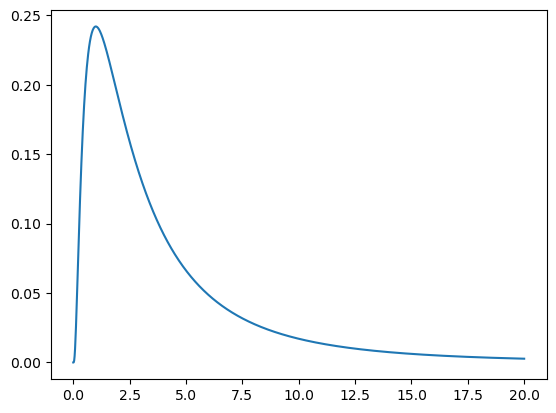

In [8]:
# Default exposure duration distribution
x = np.linspace(0, 20, 1000)
mu, sigma = 1.0, 1.0
pdf_values = lognorm.pdf(x, sigma, scale=np.exp(mu))

plt.plot(x, pdf_values)
plt.show()

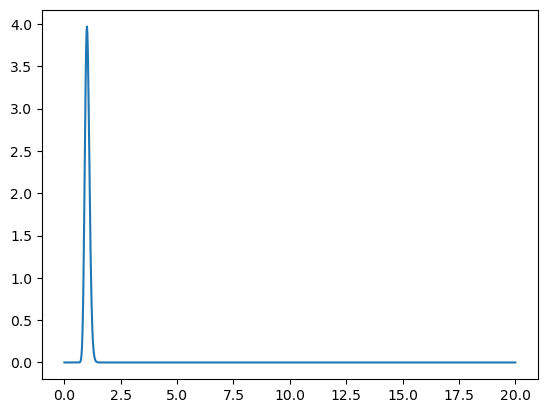

In [9]:
# Test exposure duration distribution
x = np.linspace(0, 20, 1000)
e_mu_test, e_sigma_test = 0.01, 0.1
pdf_values = lognorm.pdf(x, e_sigma_test, scale=np.exp(e_mu_test))

plt.plot(x, pdf_values)
plt.show()

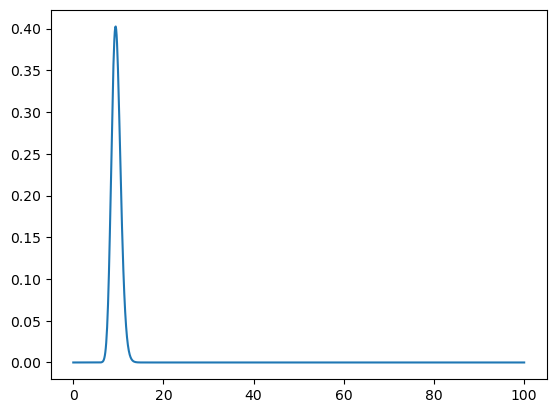

In [10]:
# Default infectious duration distribution
x = np.linspace(0, 100, 1000)
mu, sigma = 2.25, 0.105
pdf_values = lognorm.pdf(x, sigma, scale=np.exp(mu))

plt.plot(x, pdf_values)
plt.show()

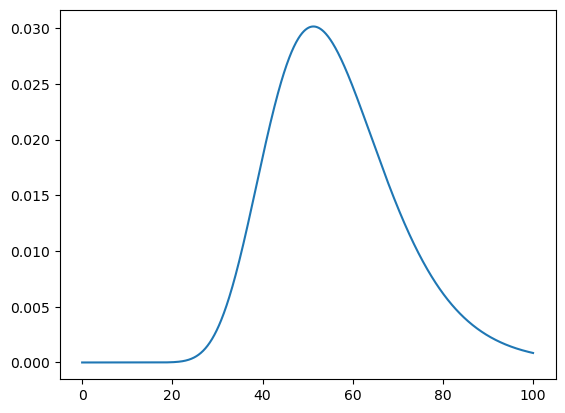

In [11]:
# Test infectious duration distribution
x = np.linspace(0, 100, 1000)
i_mu_test, i_sigma_test = 4, 0.25
pdf_values = lognorm.pdf(x, i_sigma_test, scale=np.exp(i_mu_test))

plt.plot(x, pdf_values)
plt.show()

In [89]:
def plot_infection_pdf(p_1c, beta, min_days=0, max_days=100):
    def _calculate_prob_infection(d):
        numerator = (p_1c / (1 - p_1c)) * np.exp(beta * (d ** 3 - 1))
        denominator = 1 + numerator
        
        return numerator / denominator
    
    def _pdf_to_integrate(d):
        return _calculate_prob_infection(d)

    n_days_values = np.linspace(min_days, max_days, 100)
    pdf_values = [_calculate_prob_infection(n_days) for n_days in n_days_values]

    # Normalize
    area, _ = quad(_pdf_to_integrate, min_days, max_days)
    pdf_values = np.array(pdf_values) / area

    plt.plot(n_days_values, pdf_values)
    plt.xlabel('Day')
    plt.ylabel('Probability')
    plt.title('Infection Probability')
    plt.show()

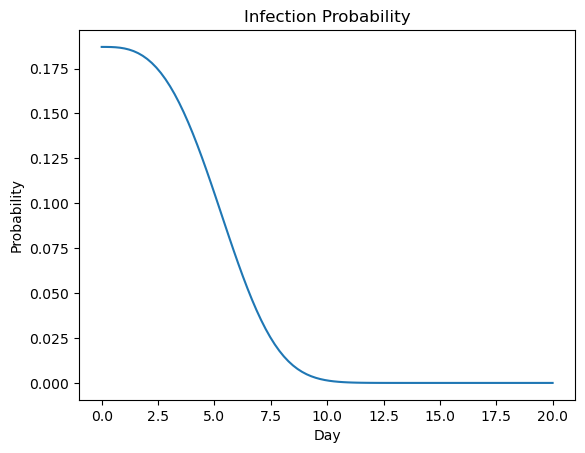

In [13]:
# Default infectious parameters
p_1c, beta = 0.12, -0.00504

plot_infection_pdf(p_1c, beta)

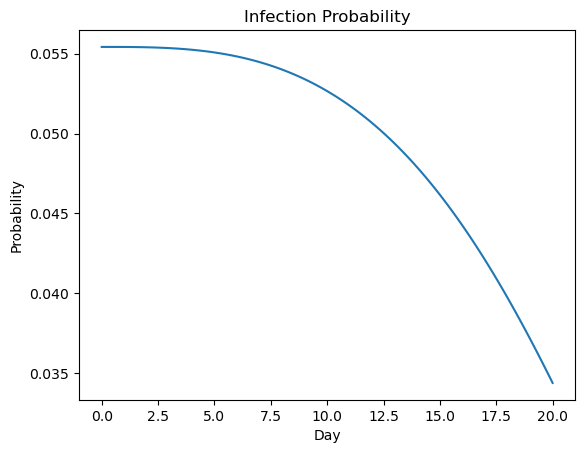

In [14]:
# Test infectious parameters
p_1c_test, beta_test = 0.5, -0.0001

plot_infection_pdf(p_1c_test, beta_test)

In [22]:
test_parameters = Parameters(False, e_mu_test, e_sigma_test, i_mu_test, i_sigma_test, p_1c_test, beta_test)

### Circulant 2

Default Parameters

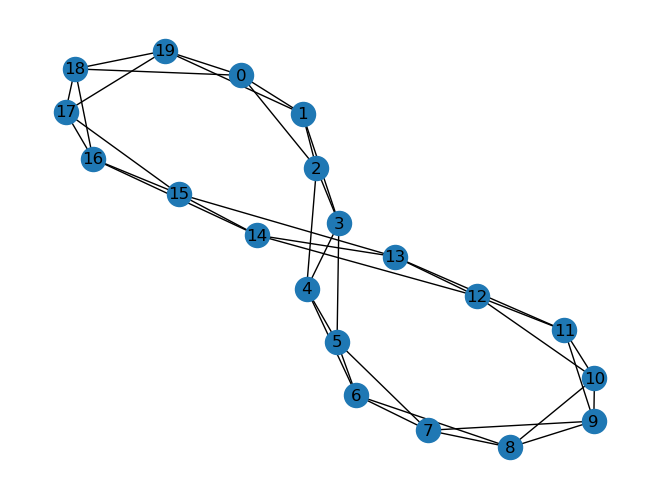

In [7]:
G = nx.circulant_graph(20, [1, 2])

nx.draw(G, with_labels=True)
plt.show()

In [8]:
population = Population(G)

In [9]:
circulant_2_sim = Simulation('circulant_2', population)

MovieWriter imagemagick unavailable; using Pillow instead.


Done with simulations; animating...


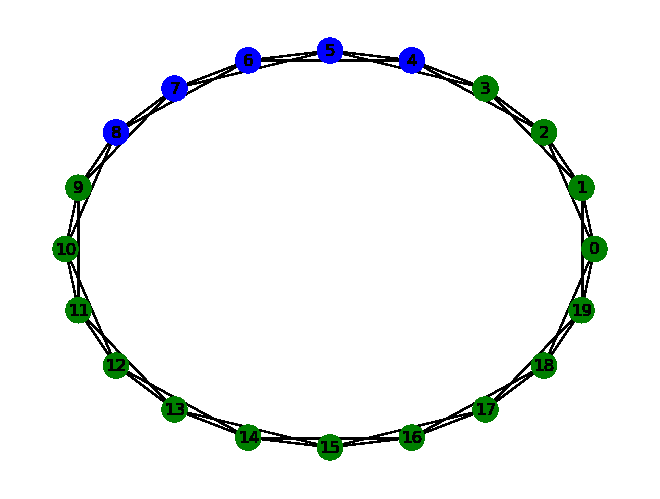

In [10]:
circulant_2_sim.run(animate=True)

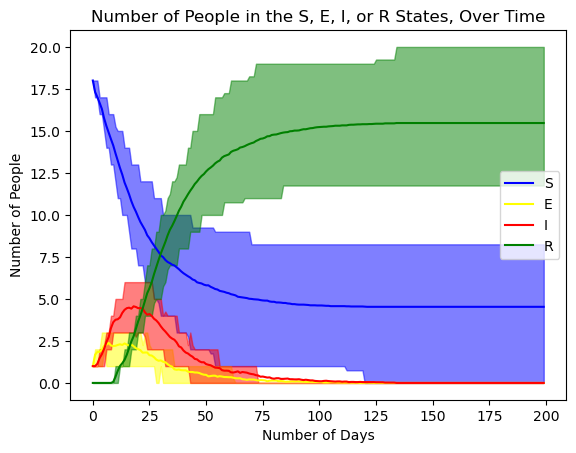

In [11]:
circulant_2_sim.plot()

In [12]:
circulant_2_sim.summary_statistics()

Number of peak infections (on average): 4.56
Time to peak infection (on average): 18
Time until no new infections (on average): 134
Number of uninfected individuals at the end of the simulation (on average): 4.53


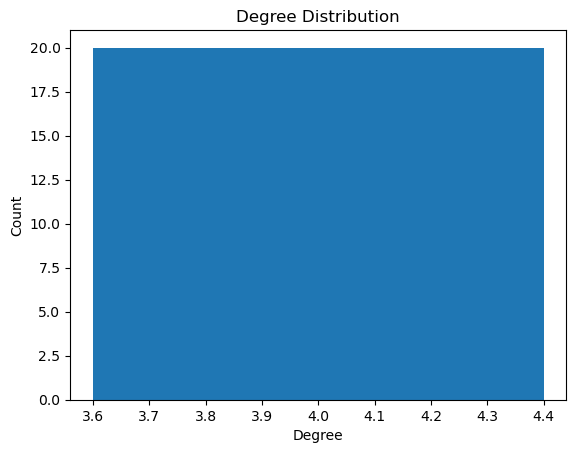

Maximum degree: 4
Average degree: 4.0
Diameter: 5
Radius: 5
Density: 0.21052631578947367


In [13]:
circulant_2_sim.graph_metrics()

### Circulant 4

 Default Parameters

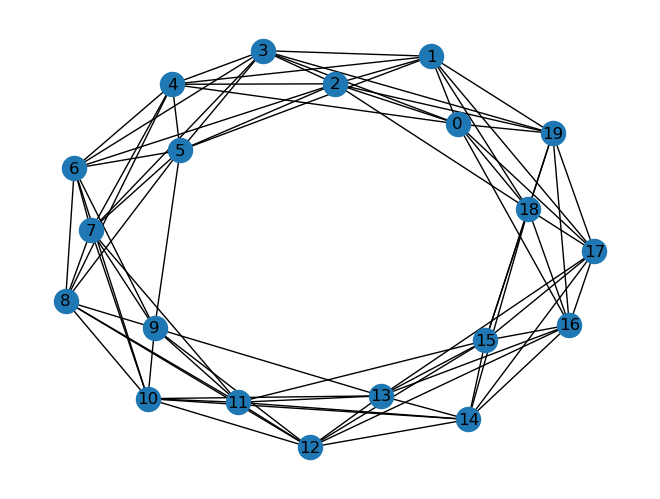

In [14]:
G = nx.circulant_graph(20, [1, 2, 3, 4])

nx.draw(G, with_labels=True)
plt.show()

In [15]:
population = Population(G)

In [16]:
circulant_4_sim = Simulation('circulant_4', population)

MovieWriter imagemagick unavailable; using Pillow instead.


Done with simulations; animating...


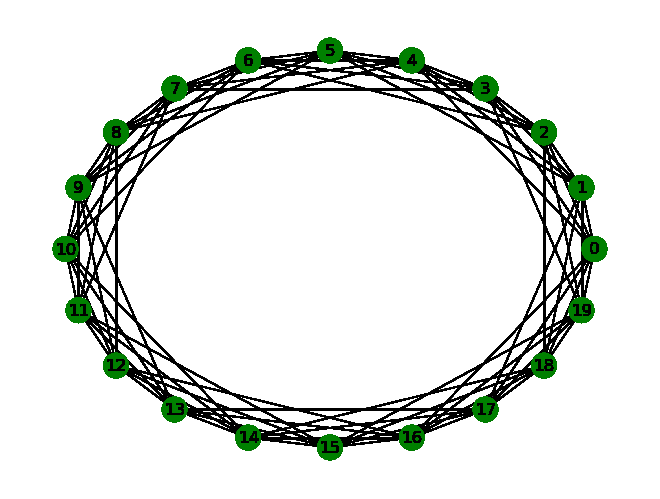

In [17]:
circulant_4_sim.run(animate=True)

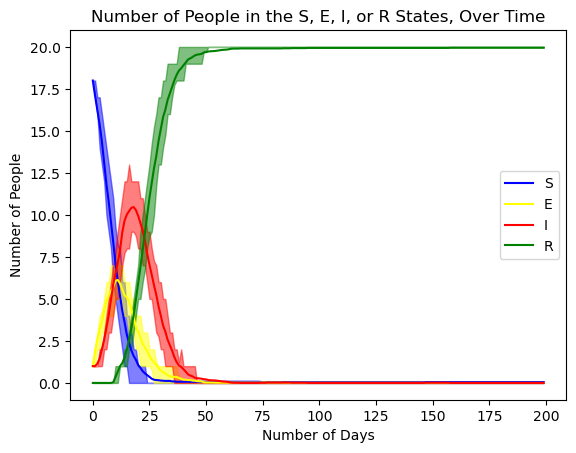

In [18]:
circulant_4_sim.plot()

In [19]:
circulant_4_sim.summary_statistics()

Number of peak infections (on average): 10.47
Time to peak infection (on average): 18
Time until no new infections (on average): 158
Number of uninfected individuals at the end of the simulation (on average): 0.05


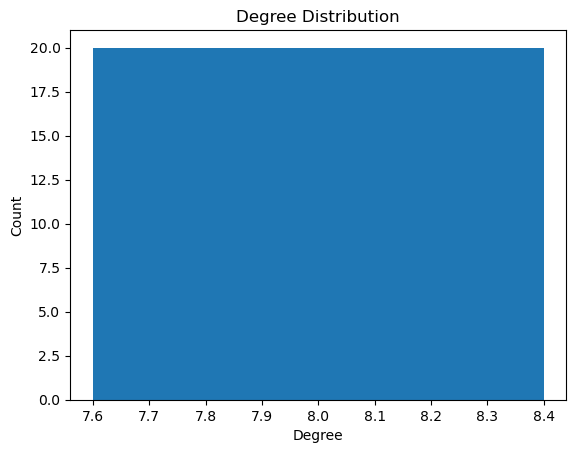

Maximum degree: 8
Average degree: 8.0
Diameter: 3
Radius: 3
Density: 0.42105263157894735


In [20]:
circulant_4_sim.graph_metrics()

### Complete

Default Parameters

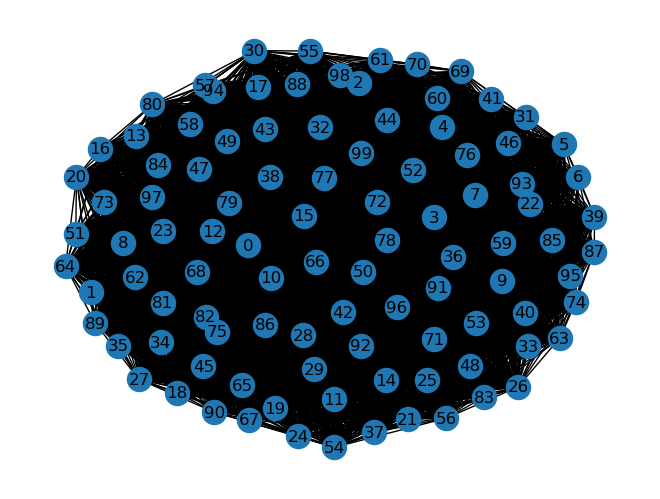

In [130]:
G = nx.complete_graph(100)

nx.draw(G, with_labels=True)
plt.show()

In [16]:
population = Population(G)

In [17]:
complete_sim = Simulation('complete', population)

In [18]:
complete_sim.run()

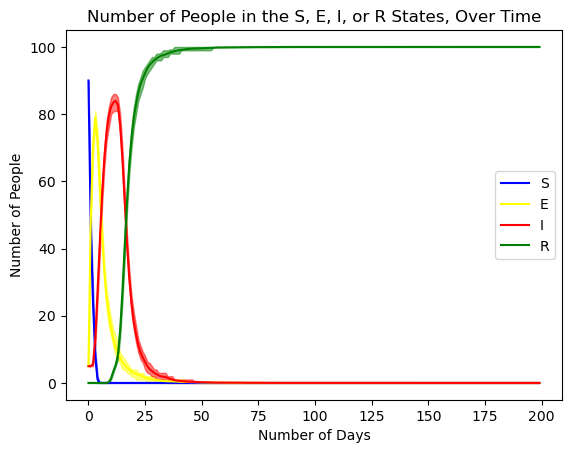

In [19]:
complete_sim.plot()

In [20]:
complete_sim.summary_statistics()

Number of peak infections (on average): 83.96
Time to peak infection (on average): 12
Time until no new infections (on average): 86
Number of uninfected individuals at the end of the simulation (on average): 0.0


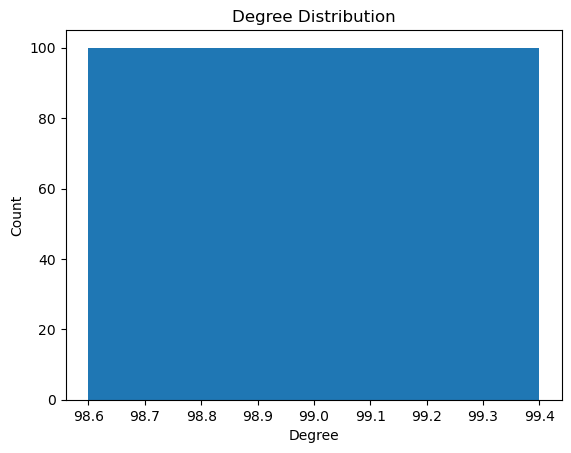

Maximum degree: 99
Average degree: 99.0
Diameter: 1
Radius: 1
Density: 1.0


In [21]:
complete_sim.graph_metrics()

Test Parameters

In [23]:
population = Population(G, parameters=test_parameters)

In [24]:
complete_sim_test = Simulation('complete_test', population)

In [25]:
complete_sim_test.run()

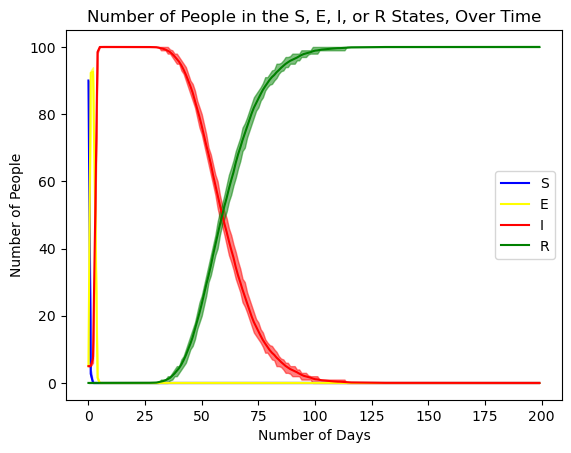

In [26]:
complete_sim_test.plot()

In [27]:
complete_sim_test.summary_statistics()

Number of peak infections (on average): 100.0
Time to peak infection (on average): 6
Time until no new infections (on average): 136
Number of uninfected individuals at the end of the simulation (on average): 0.0


### Lattice

Default Parameters

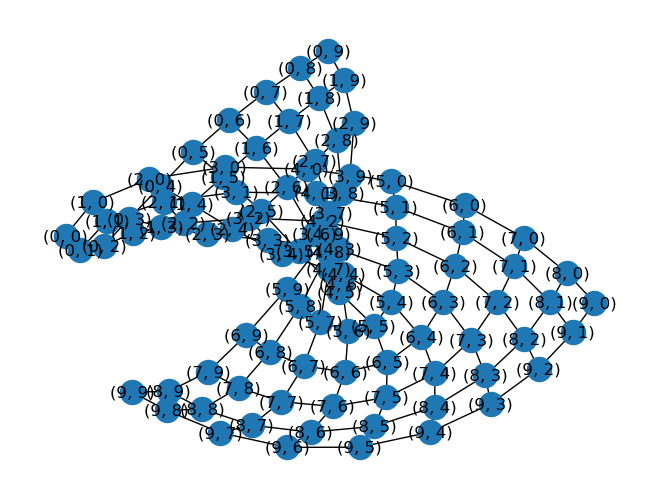

In [139]:
G = nx.grid_2d_graph(10, 10)

nx.draw(G, with_labels=True)
plt.show()

In [30]:
population = Population(G)

In [31]:
lattice_sim = Simulation('lattice', population)

In [32]:
lattice_sim.run()

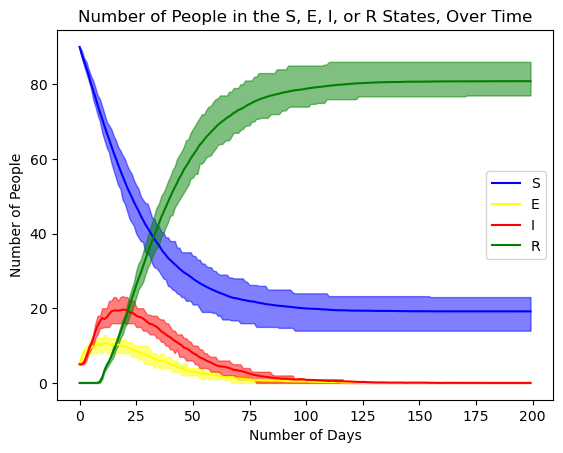

In [33]:
lattice_sim.plot()

In [34]:
lattice_sim.summary_statistics()

Number of peak infections (on average): 19.64
Time to peak infection (on average): 19
Time until no new infections (on average): 178
Number of uninfected individuals at the end of the simulation (on average): 19.17


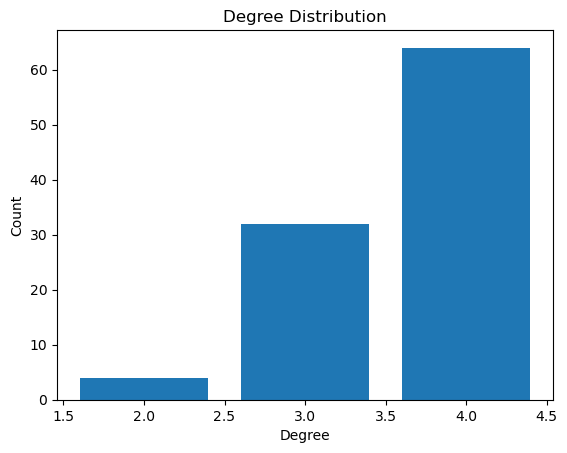

Maximum degree: 4
Average degree: 3.6
Diameter: 18
Radius: 10
Density: 0.03636363636363636


In [35]:
lattice_sim.graph_metrics()

Test Parameters

In [36]:
population = Population(G, parameters=test_parameters)

In [37]:
lattice_sim_test = Simulation('lattice_test', population)

In [38]:
lattice_sim_test.run()

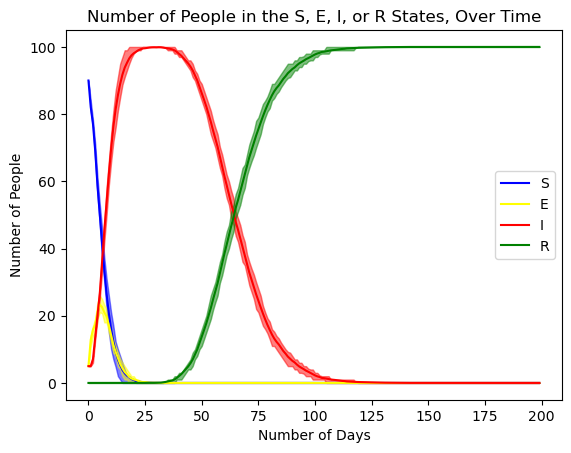

In [39]:
lattice_sim_test.plot()

In [40]:
lattice_sim_test.summary_statistics()

Number of peak infections (on average): 99.92
Time to peak infection (on average): 31
Time until no new infections (on average): 140
Number of uninfected individuals at the end of the simulation (on average): 0.0


### Scale-Free 100

Default Parameters

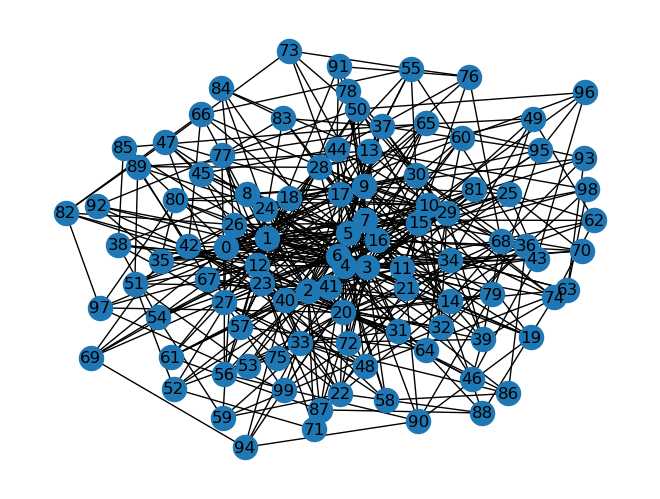

In [145]:
G = nx.barabasi_albert_graph(100, 5, initial_graph=nx.complete_graph(5))

nx.draw(G, with_labels=True)
plt.show()

In [42]:
population = Population(G)

In [43]:
scale_free_100_sim = Simulation('scale_free_100', population)

In [44]:
scale_free_100_sim.run()

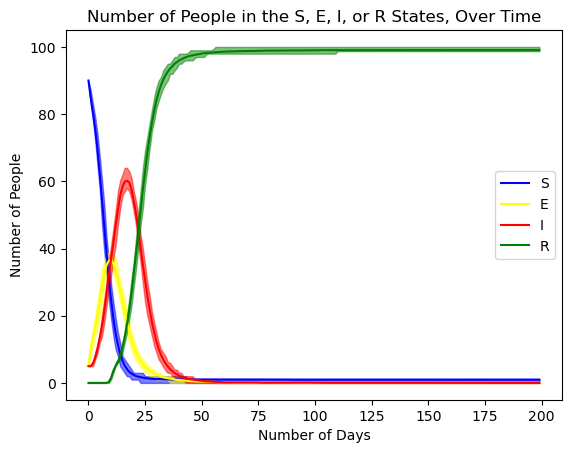

In [45]:
scale_free_100_sim.plot()

In [46]:
scale_free_100_sim.summary_statistics()

Number of peak infections (on average): 60.13
Time to peak infection (on average): 17
Time until no new infections (on average): 109
Number of uninfected individuals at the end of the simulation (on average): 0.95


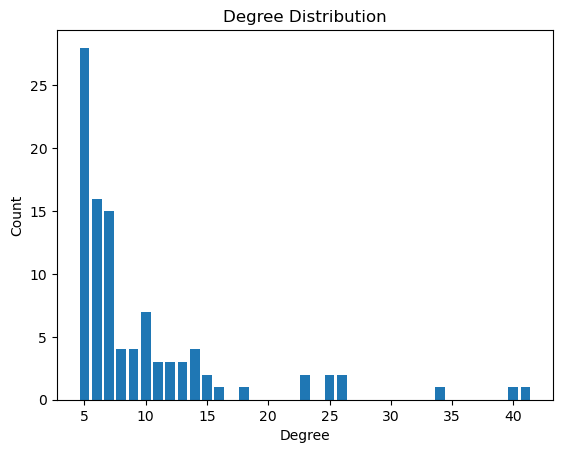

Maximum degree: 41
Average degree: 9.7
Diameter: 4
Radius: 2
Density: 0.09797979797979799


In [47]:
scale_free_100_sim.graph_metrics()

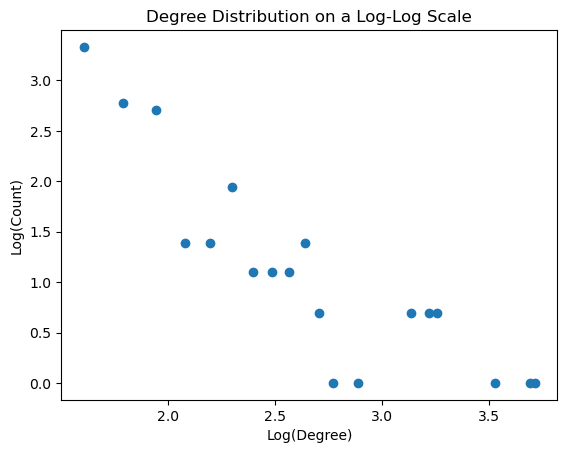

In [48]:
scale_free_100_sim.log_log_density_plot()

Test Parameters

In [49]:
population = Population(G, parameters=test_parameters)

In [50]:
scale_free_100_sim_test = Simulation('scale_free_100_test', population)

In [51]:
scale_free_100_sim_test.run()

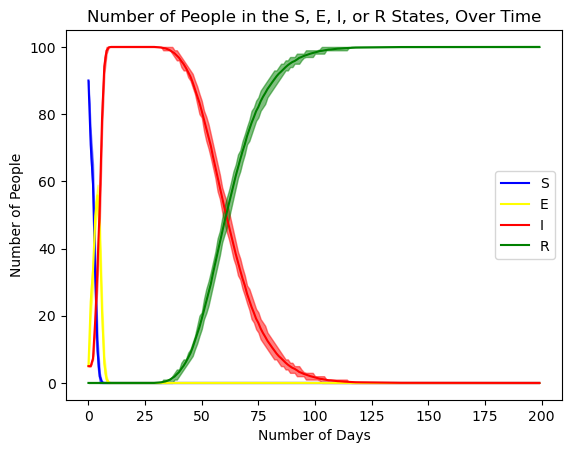

In [52]:
scale_free_100_sim_test.plot()

In [53]:
scale_free_100_sim_test.summary_statistics()

Number of peak infections (on average): 100.0
Time to peak infection (on average): 10
Time until no new infections (on average): 153
Number of uninfected individuals at the end of the simulation (on average): 0.0


### Scale-Free 410

Default Parameters

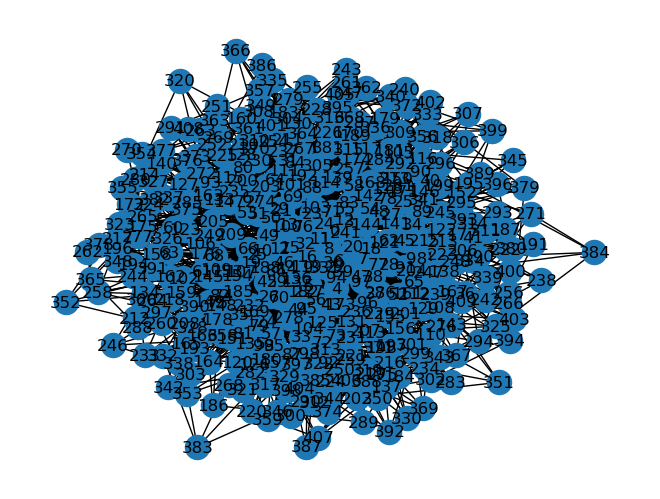

In [54]:
G = nx.barabasi_albert_graph(410, 5, initial_graph=nx.complete_graph(5))

nx.draw(G, with_labels=True)
plt.show()

In [55]:
population = Population(G)

In [56]:
scale_free_410_sim = Simulation('scale_free_410', population)

In [57]:
scale_free_410_sim.run()

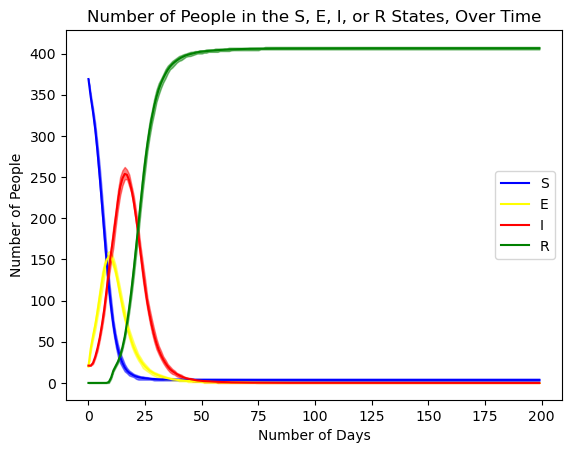

In [58]:
scale_free_410_sim.plot()

In [59]:
scale_free_410_sim.summary_statistics()

Number of peak infections (on average): 253.81
Time to peak infection (on average): 16
Time until no new infections (on average): 144
Number of uninfected individuals at the end of the simulation (on average): 3.64


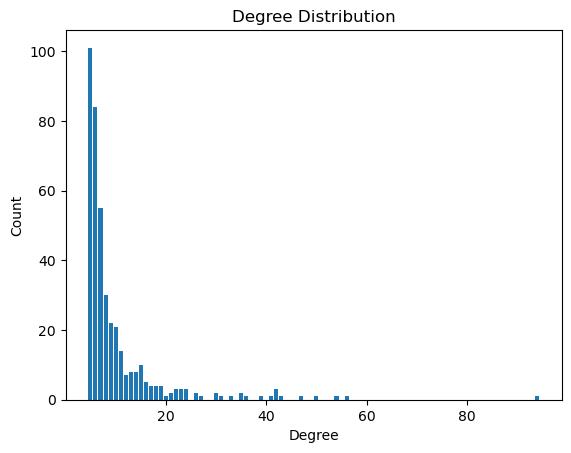

Maximum degree: 94
Average degree: 9.926829268292684
Diameter: 4
Radius: 3
Density: 0.02427097620609458


In [60]:
scale_free_410_sim.graph_metrics()

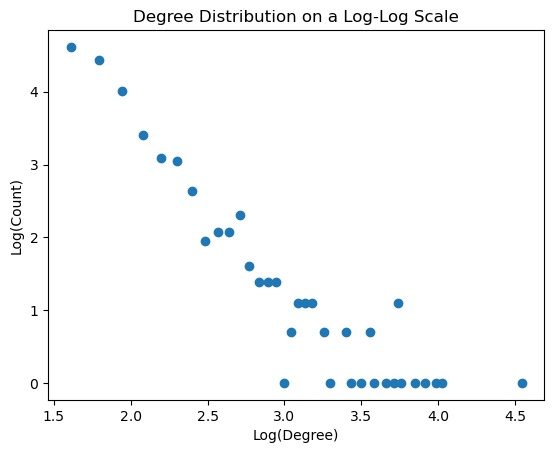

In [61]:
scale_free_410_sim.log_log_density_plot()

Test Parameters

In [62]:
population = Population(G, parameters=test_parameters)

In [63]:
scale_free_410_sim_test = Simulation('scale_free_410_test', population)

In [64]:
scale_free_410_sim_test.run()

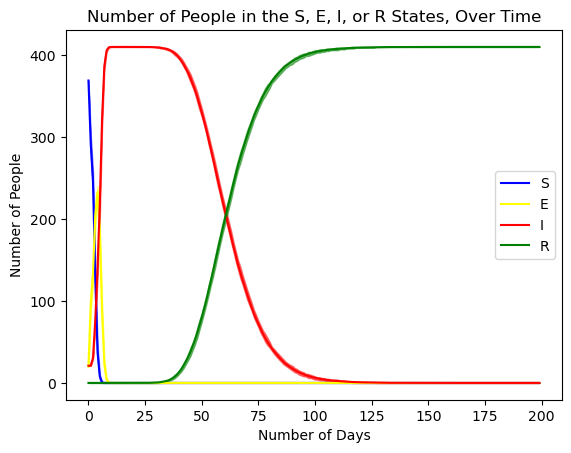

In [65]:
scale_free_410_sim_test.plot()

In [66]:
scale_free_410_sim_test.summary_statistics()

Number of peak infections (on average): 410.0
Time to peak infection (on average): 11
Time until no new infections (on average): 155
Number of uninfected individuals at the end of the simulation (on average): 0.0


### Infect Dublin

Default Parameters

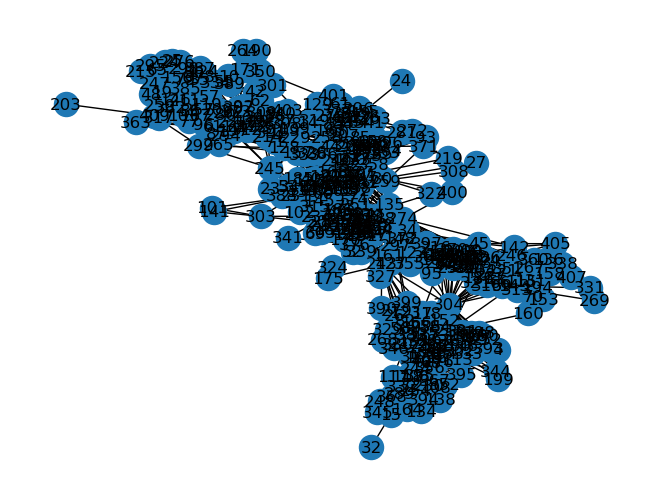

In [151]:
# Code from the lab specs (used to read in the Dublin graph)
def _read_graph_from_file(filename):
    fo = open(filename, 'r')
    line = fo.readline()  # Read file header
    line = fo.readline()  # Number of vertices and edges
    if not line:
        print('error -- illegal format for input')
        return
    v = line.split(" ")
    numVertices = int(v[0])
    G = nx.Graph()
    G.add_nodes_from(range(1,numVertices+1))
    while True:
        line = fo.readline()
        if not line:
            break
        #print("Line{}: {}".format(count,line.strip()))
        v = line.split(" ")
        v1 = int(v[0])
        v2 = int(v[1])
        G.add_edge(v1,v2)
        G.add_edge(v2,v1)
    fo.close()
    return G

G = _read_graph_from_file('./project_1_files/ia-infect-dublin.mtx')

nx.draw(G, with_labels=True)
plt.show()

In [68]:
population = Population(G)

In [69]:
infect_dublin_sim = Simulation('infect_dublin', population)

In [70]:
infect_dublin_sim.run()

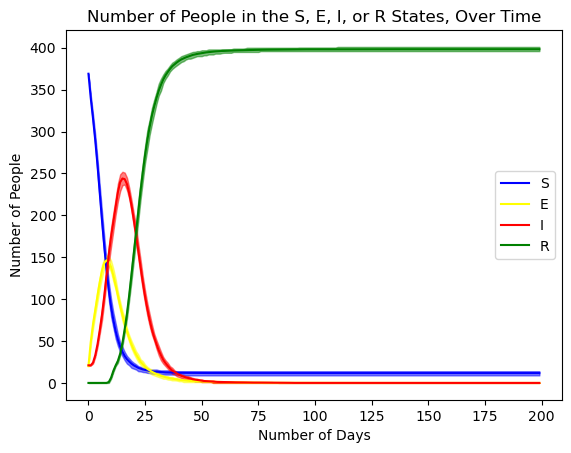

In [71]:
infect_dublin_sim.plot()

In [72]:
infect_dublin_sim.summary_statistics()

Number of peak infections (on average): 243.97
Time to peak infection (on average): 15
Time until no new infections (on average): 165
Number of uninfected individuals at the end of the simulation (on average): 11.73


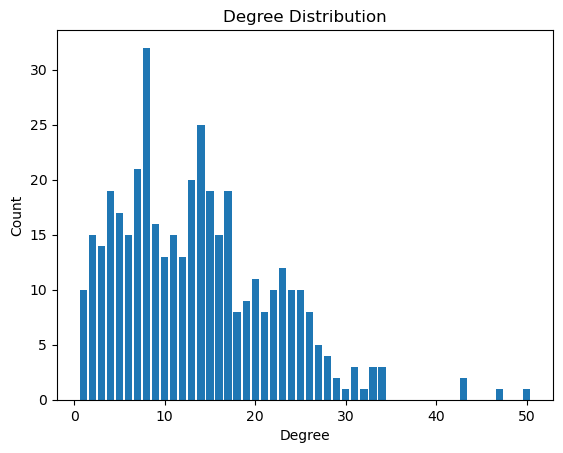

Maximum degree: 50
Average degree: 13.487804878048781
Diameter: 9
Radius: 5
Density: 0.032977518039239075


In [73]:
infect_dublin_sim.graph_metrics()

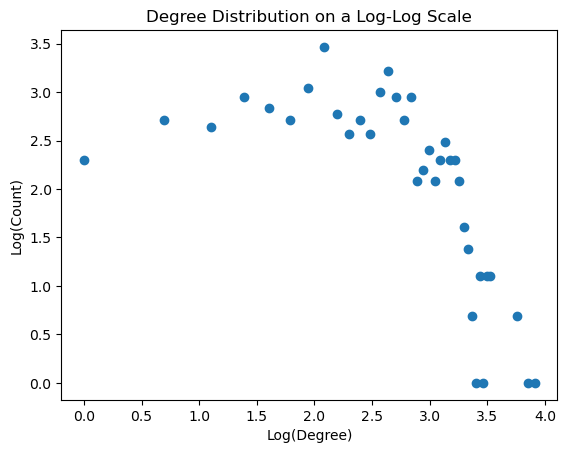

In [74]:
infect_dublin_sim.log_log_density_plot()

Test Parameters

In [75]:
population = Population(G, parameters=test_parameters)

In [76]:
infect_dublin_sim_test = Simulation('infect_dublin_test', population)

In [77]:
infect_dublin_sim_test.run()

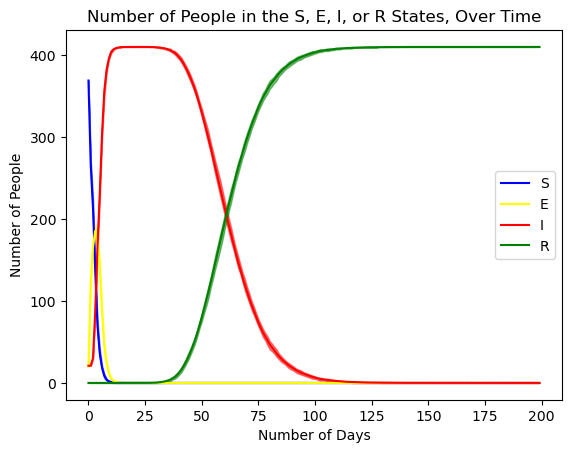

In [78]:
infect_dublin_sim_test.plot()

In [79]:
infect_dublin_sim_test.summary_statistics()

Number of peak infections (on average): 409.99
Time to peak infection (on average): 20
Time until no new infections (on average): 156
Number of uninfected individuals at the end of the simulation (on average): 0.0


Masks

In [152]:
population = Population(G, parameters=Parameters(masks=True))

In [153]:
infect_dublin_sim_masks = Simulation('infect_dublin_masks', population)

In [154]:
infect_dublin_sim_masks.run()

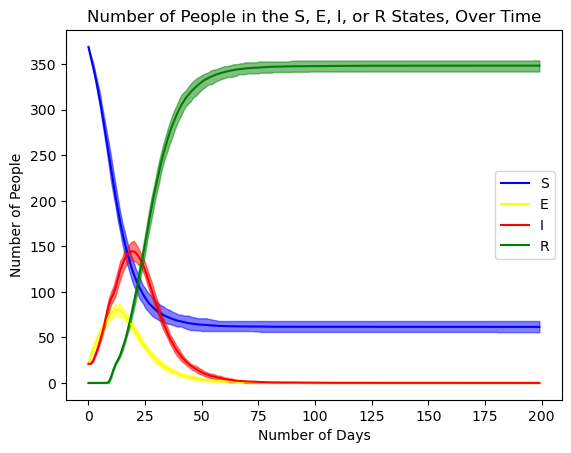

In [155]:
infect_dublin_sim_masks.plot()

In [156]:
infect_dublin_sim_masks.summary_statistics()

Number of peak infections (on average): 144.48
Time to peak infection (on average): 20
Time until no new infections (on average): 180
Number of uninfected individuals at the end of the simulation (on average): 61.52


# Report

### Names

Ethan Pedersen

### Abstract

I created 7 networks and ran the SEIR model on them.  I also used a custom set of parameters to compare results and experimented with the effect of masks in one of the simulations.  I learned that graph structure can have a significant impact on the spread of a disease (dense and/or small diameters tends to encourage spread, and vice versa).

### Introduction

I personally found this project to be interesting because we recently experienced a pandemic, so it was fun to experiment with disease spread over different networks and with various parameters.  As instructed, I used the SEIR model on seven different networks.  I also selected custom parameters that would encourage spread (see the next section).  The rest of the report is as follows:

<ul>
    <li> Experiment Conditions: Provides details about the parameters I chose.
    <li> Animations: Shows where one can find the animations for the circulant graphs.
    <li> Summary Table (Default Parameters): Includes a table of the summary statistics for simulations that used the default parameters.
    <li> Summary Table (My Parameters): Includes a table of the summary statistics for simulations that used my custom parameters.
    <li> Degree Distributions: Shows a degree distribution plot for every graph (except the circulant graphs, since those were for testing/debugging purposes).
    <li> Hypotheses: Describes various hypotheses I made before running the simulations.
    <li> Discussion: Expands on each hypothesis (if they were true or false, and why).  I also show a few interesting simulaton plots in this section.
    <li> Future Work: A brief description on what I would work on next and what I wish I had done differently.
</ul>

### Experiment Conditions

For my scale-free networks, I used an m of 5 and a complete graph as the initial graph (for both the 100-node and 410-node networks).  I used a complete graph as the initial graph because, at least according to the lecture slides, the initial steps of the Barabasi-Albert algorithm involve creating a complete graph.  I used an m of 5 because my results from homework 3 seemed to show that a smaller m worked better for a smaller number of iterations (nodes).  To double check, we can see that both networks seems to pass the line test on the log-log degree distribution plot:

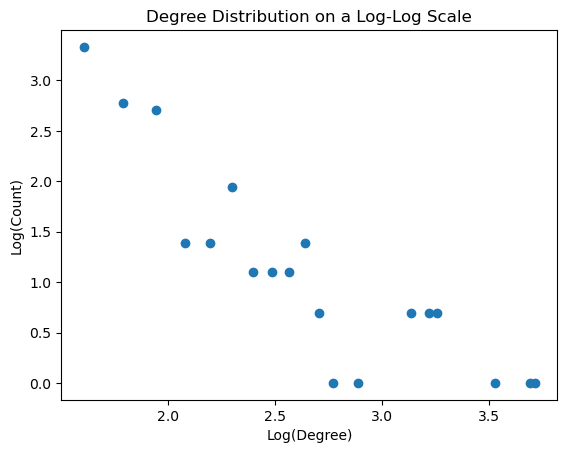

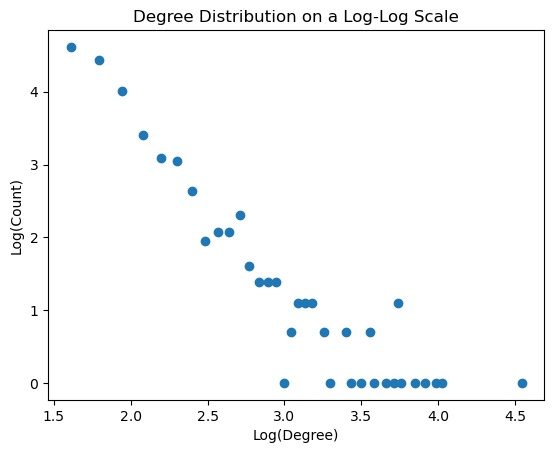

In [81]:
scale_free_100_sim.log_log_density_plot()
scale_free_410_sim.log_log_density_plot()

For exposure duration, I used a mean of 0.01 and a sigma of 0.1.  For infectious duration, I used a mu of 4 and a sigma of 0.25.  For infectious level, I used a p_1c of 0.5 and a beta of -0.0001.  I chose these parameters in an effort to boost the spread of infection.  The exposure duration parameters lead to shorter exposure periods, on average:

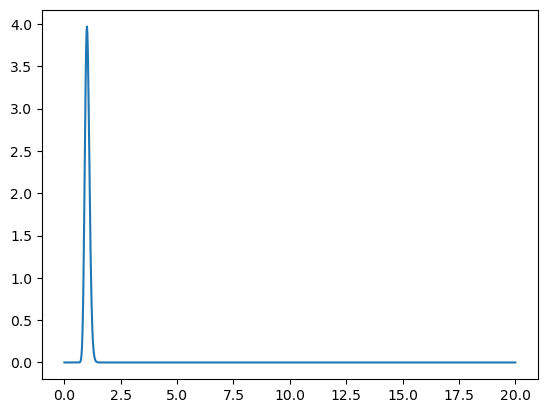

In [85]:
# Test exposure duration distribution
x = np.linspace(0, 20, 1000)
e_mu_test, e_sigma_test = 0.01, 0.1
pdf_values = lognorm.pdf(x, e_sigma_test, scale=np.exp(e_mu_test))

plt.plot(x, pdf_values)
plt.show()

The infectious duration parameters lead to longer infectious periods, on average:

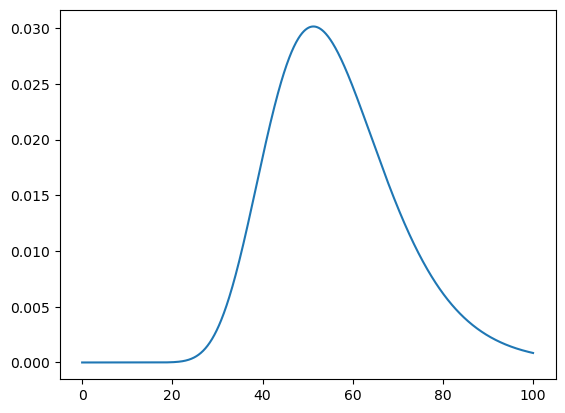

In [86]:
# Test infectious duration distribution
x = np.linspace(0, 100, 1000)
i_mu_test, i_sigma_test = 4, 0.25
pdf_values = lognorm.pdf(x, i_sigma_test, scale=np.exp(i_mu_test))

plt.plot(x, pdf_values)
plt.show()

Finally, the infectious level parameters lead to stronger probabilities of spreading the disease, on average:

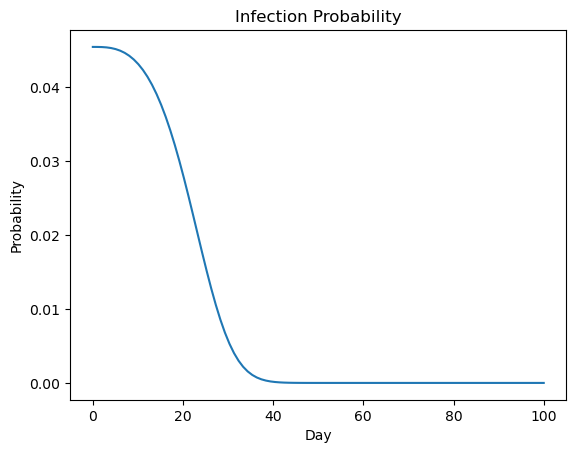

In [90]:
# Test infectious parameters
p_1c_test, beta_test = 0.5, -0.0001

plot_infection_pdf(p_1c_test, beta_test)

### Animations

The animations for the circulant graphs can be found in the project_1_animations folder.

### Summary Table (Default Parameters)

In [119]:
pd.DataFrame({
    'Network': [complete_sim.name, lattice_sim.name, scale_free_100_sim.name, scale_free_410_sim.name, 
                infect_dublin_sim.name],
    'Maximum Degree': [99, 4, 41, 94, 50],
    'Average Degree': [99.0, 3.6, 9.7, 9.927, 13.488],
    'Diameter': [1, 18, 4, 4, 9],
    'Radius': [1, 10, 2, 3, 5],
    'Density': [1.0, 0.036, 0.098, 0.024, 0.033],
    'Num Peak Infections': [83.96, 19.64, 60.13, 253.81, 243.97],
    'Time to Peak Infections': [12, 19, 17, 16, 15],
    'Time Until No New Infections': [86, 178, 109, 144, 165],
    'Num Uninfected Individuals': [0.0, 19.17, 0.95, 3.64, 11.73]
})

,Network,Maximum Degree,Average Degree,Diameter,Radius,Density,Num Peak Infections,Time to Peak Infections,Time Until No New Infections,Num Uninfected Individuals
0,complete,99,99.000,1,1,1.000,83.96,12,86,0.00
1,lattice,4,3.600,18,10,0.036,19.64,19,178,19.17
2,scale_free_100,41,9.700,4,2,0.098,60.13,17,109,0.95
3,scale_free_410,94,9.927,4,3,0.024,253.81,16,144,3.64
4,infect_dublin,50,13.488,9,5,0.033,243.97,15,165,11.73


### Summary Table (My Parameters)

Note: The graph metrics are the same (we weren't asked to change the networks)

In [125]:
pd.DataFrame({
    'Network': [complete_sim_test.name, lattice_sim_test.name, scale_free_100_sim_test.name, 
                scale_free_410_sim_test.name, infect_dublin_sim_test.name],
    'Maximum Degree': [99, 4, 41, 94, 50],
    'Average Degree': [99.0, 3.6, 9.7, 9.927, 13.488],
    'Diameter': [1, 18, 4, 4, 9],
    'Radius': [1, 10, 2, 3, 5],
    'Density': [1.0, 0.036, 0.098, 0.024, 0.033],
    'Num Peak Infections': [100.0, 99.92, 100.0, 410.0, 409.99],
    'Time to Peak Infections': [6, 31, 10, 11, 20],
    'Time Until No New Infections': [136, 140, 153, 155, 156],
    'Num Uninfected Individuals': [0.0, 0.0, 0.0, 0.0, 0.0]
})

,Network,Maximum Degree,Average Degree,Diameter,Radius,Density,Num Peak Infections,Time to Peak Infections,Time Until No New Infections,Num Uninfected Individuals
0,complete_test,99,99.000,1,1,1.000,100.00,6,136,0.0
1,lattice_test,4,3.600,18,10,0.036,99.92,31,140,0.0
2,scale_free_100_test,41,9.700,4,2,0.098,100.00,10,153,0.0
3,scale_free_410_test,94,9.927,4,3,0.024,410.00,11,155,0.0
4,infect_dublin_test,50,13.488,9,5,0.033,409.99,20,156,0.0


### Degree Distributions

Complete

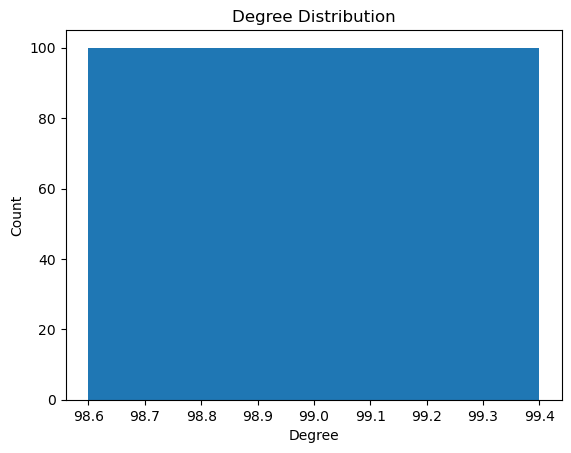

Maximum degree: 99
Average degree: 99.0
Diameter: 1
Radius: 1
Density: 1.0


In [120]:
complete_sim.graph_metrics()

Lattice

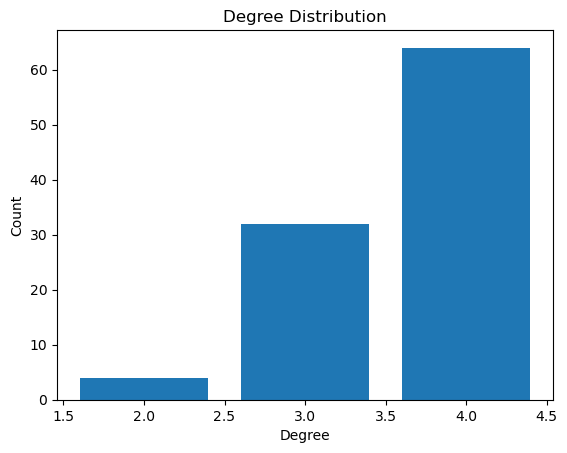

Maximum degree: 4
Average degree: 3.6
Diameter: 18
Radius: 10
Density: 0.03636363636363636


In [121]:
lattice_sim.graph_metrics()

Scale-Free (100 Nodes)

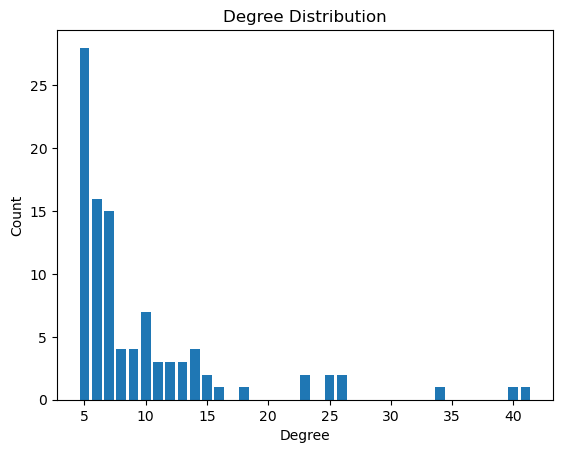

Maximum degree: 41
Average degree: 9.7
Diameter: 4
Radius: 2
Density: 0.09797979797979799


In [122]:
scale_free_100_sim.graph_metrics()

Scale-Free (410 Nodes)

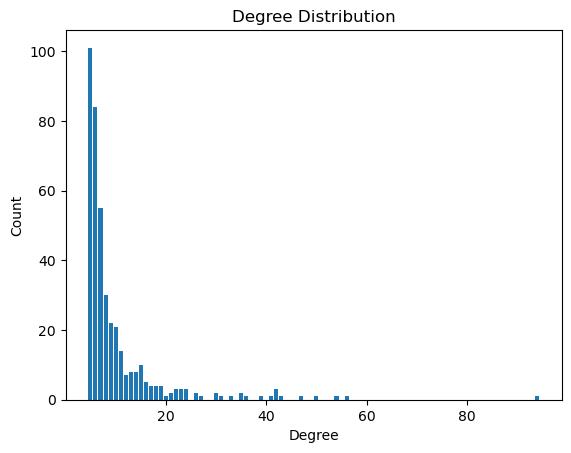

Maximum degree: 94
Average degree: 9.926829268292684
Diameter: 4
Radius: 3
Density: 0.02427097620609458


In [123]:
scale_free_410_sim.graph_metrics()

Dublin

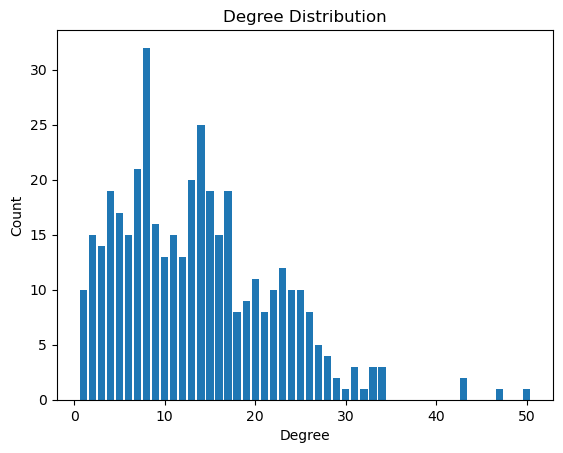

Maximum degree: 50
Average degree: 13.487804878048781
Diameter: 9
Radius: 5
Density: 0.032977518039239075


In [124]:
infect_dublin_sim.graph_metrics()

### Hypotheses

Here are some hypotheses I made before running the simulations:

<ol>
    <li> Everyone will get infected at some point in the complete graph.  This is due to its density of 1 (everyone is connected to everyone else, so the infection is more likely to spread to everyone).  Not everyone will get infected in any of the other graphs, with exception of possibly the scale-free networks (if a superspreader gets the disease, everyone will probably get infected).
    <li> The time to peak infection will be the smallest for the complete graph.  Again, this is due to its density of 1.
    <li> The lattice graph will have the largest time to peak infection.  This network has the second-smallest density (slightly larger than the density of the scale-free network with 410 nodes), but it has the largest diameter and radius (it takes longer for the virus to spread across the network).
    <li> The lattice graph's number of peak infections will be smaller than the complete graph and scale-free graph with 100 nodes (both of those graphs have 100 nodes, the same as the lattic graph).  The lattice graph has the smallest density of the three and the largest diameter and radius of the three.
    <li> The scale-free graph with 100 nodes will have a smaller number of peak infections and a longer time to peak infections when compared to the complete graph.
    <li> Compared to the Dublin network, the scale-free graph with 410 nodes will have a larger number of peak infections and a shorter time to reach peak infections.  Even though its density is slightly smaller, its diameter and radius are also smaller.
    <li> Everyone will get infected in every graph for my custom parameters (they encourage virus spread).
    <li> Compared to the default parameters, the time to spread will be smaller for every graph when using my custom parameters.
</ol>

### Discussion

I will discuss each point of the Hypotheses section, in the same order:

<ol>
    <li> My hypothesis about everyone getting infected in the complete graph was correct.  Again, this is probably due to the full density of the graph combined with both a diamter and radius of 1.  Furthermore, my hypothesis that not everyone would get infected in the other graphs was mainly correct.  One could argue that no one was uninfected in the scale-free graph with 100 nodes (the number of uninfected individuals, on average, was 0.95; if one were to round down, that would be 0).  Interestingly, the number of uninfected individuals in the scale-free graph with 410 nodes was larger.  If I had to guess why, it would be that there are still roughly the same number of superspreaders, but with more individuals in the graph (larger number of nodes) there's a smaller chance of everyone being infected.
    <li> My second hypothesis was also correct (the time to peak infection was smallest for the complete graph).  This wasn't very surprising, though I actually expected it to be smaller (it was about 12, on average).
    <li> The third hypothesis was also correct.  Again, I believe that the time to spread for the lattice graph was largest because its density is tied (roughly) for second-smallest, while its diameter and radius are the largest (by a good amount) of all the graphs.  In other words, individual nodes are not very connected and the virus would have to travel a longer distance to traverse the graph.
    <li> This hypothesis was also correct (same explanation as the previous hypothesis).
    <li> The fifth hypothesis was also correct.  Based on the explanations for the previous hypotheses, this again isn't very suprising (the complete graph has a full density, while the scale-free graph is much more sparse and has a larger diamter and radius).
    <li> This hypothesis was partially correct.  While the scale-free network with 410 nodes had a larger number of peak infections, the Dublin network had a (slightly) smaller time to peak infections.  If I had to guess why, it would be that, due to the smaller density of the scale-free network, the time to reach peak infections was slightly larger (not as connected, so the virus took slightly longer to spread).  However, the diameter and density of the scale-free network are smaller, which is probably why the number of peak infections was slightly larger (the distance the virus had to travel was smaller).
    <li> This hypothesis was also correct.  The custom parameters I used were designed to favor rapid and intense spread.
    <li> The final hypothesis was also correct (same explanation as the previous hypothesis).
</ol>

Aside from the hypotheses, I also want to include a few graphs that I found interesting.  The first is for the lattice graph (default parameters):

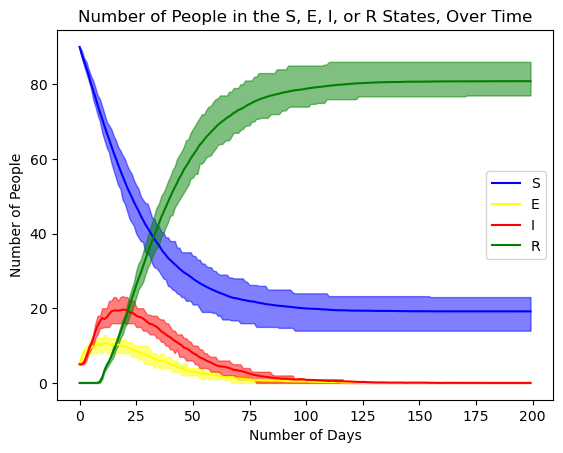

In [127]:
lattice_sim.plot()

In terms of spread of infection, the lattice graph provided the best outcome (smaller amount of peak infections and longer time to reach peak infections).  However, I found it interesting that this plot has the largest IQRs of any other.

I also found it interesting that the plot structures of both scale-free networks are very similar (just on a different y-axis scale due to the different number of nodes):

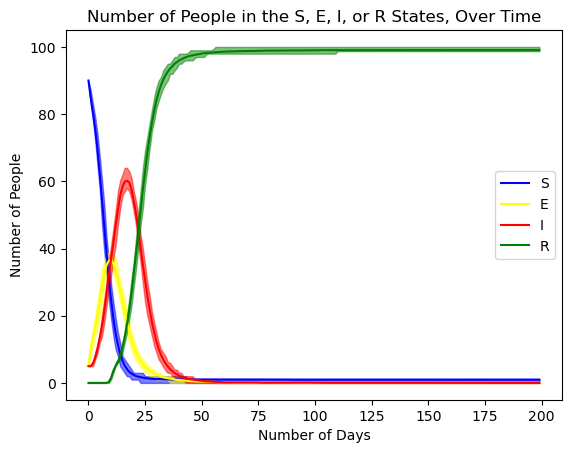

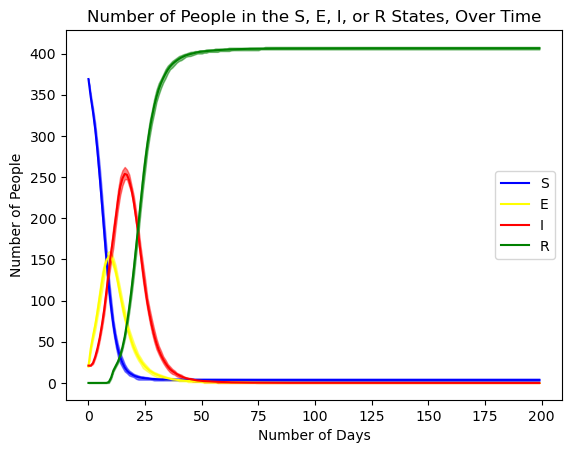

In [128]:
scale_free_100_sim.plot()
scale_free_410_sim.plot()

I suppose this isn't very suprising because the networks have roughly the same structure, but it was still kind of cool to see (in my opinion).

Additionally, I know we weren't asked to do this but I thought it would be fun to run a simulation with masks (multiply p_1c by 0.35, according to the lab specs).  I used the Dublin graph to see how much masks would change the results.  Here are the plots for the regular simulation (default parameters), and the simulation with masks (default parameters, but with masks as an additional parameter):

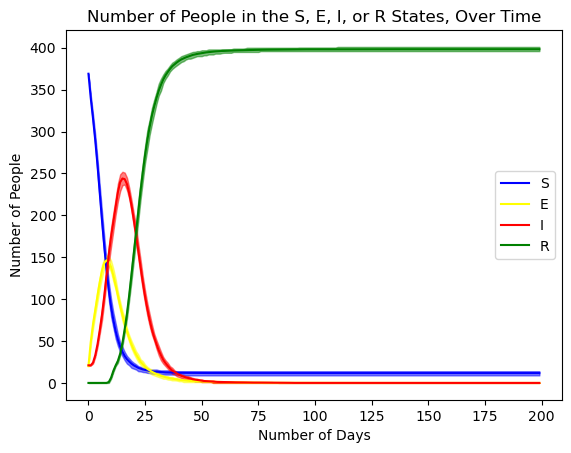

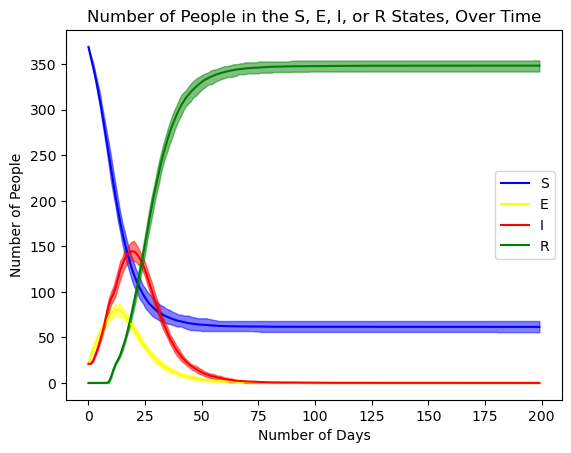

In [157]:
infect_dublin_sim.plot()
infect_dublin_sim_masks.plot()

Masks definitely seemed to impact the results.  The number of peak infections is smaller, the time to reach peak infections is larger, and the number of uninfected individuals is larger.

Finally, I want to include one plot from a simulation that used my custom parameters.  Since we just saw the lattic graph plot for the default parameters, I think it would be fun just to compare it with my parameters:

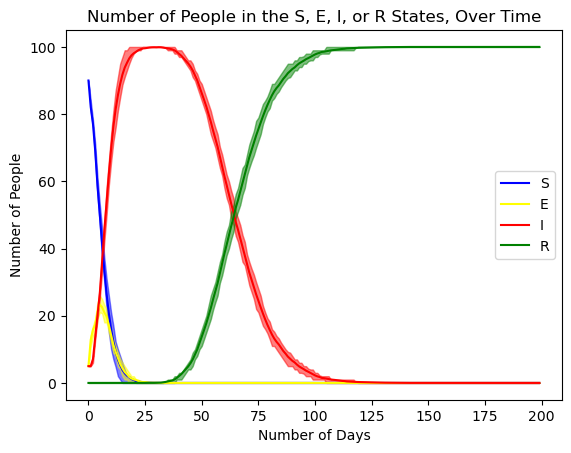

In [129]:
lattice_sim_test.plot()

Compared with the first lattice network plot we saw, we can see that, depsite the favorable conditions of the lattice graph, everyone was eventually infected with the disease.  However, the time to reach the peak number of infections was larger.

### Future Work

Given enough time, I think it would be interesting to expand this to complex contagion.  Maybe complex contagion isn't as realistic for something like a disease, but it would be interesting to see how something like a fad (usually requires multiple people to sway an individual's opinion) could spread depending on network architecture.

While I think I did at least a decent job on this project, I personally wish I coded things up a little better.  I think my biggest gripe is not creating a way to automatically extract the simulation results (right now I just print them, which means I had to hand-code the summary tables).  This would have also given me more time to analyze the results.